In [1]:
# imports
import os
import numpy as np
import time
from tinygrad import Tensor
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

os.environ['GPU'] = '1' # set to tinygrad backend to GPU since METAL doesn't work on older intel macs

In [2]:
# import and clean pokemon name data

import csv

names = []

with open('Pokemon_moves.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader) # skips header row
    for row in reader:
        if len(row) > 1:
            names.append(row[1])

In [3]:
names[:10]

['Bulbasaur',
 'Ivysaur',
 'Venusaur',
 'VenusaurMega Venusaur',
 'Charmander',
 'Charmeleon',
 'Charizard',
 'CharizardMega Charizard X',
 'CharizardMega Charizard Y',
 'Squirtle']

In [4]:
len(names)

800

In [5]:
# build the vocabular of characters and mappings to/from integers
chars = sorted(list(set(''.join(names))))
# stoi = string to int, itos = int to string
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['|'] = 0 # set | as end char, since all other end chars are already used
itos = {i:s for s,i in stoi.items()}
print(itos)

# finding # of unique chars so we can set our Tensor dim. later
all_chars = set(''.join(stoi))
num_unique_chars = len(all_chars)

print('num_unique_chars =', num_unique_chars)
print('all_chars = ', all_chars)

{1: ' ', 2: '%', 3: "'", 4: '-', 5: '.', 6: '0', 7: '2', 8: '5', 9: 'A', 10: 'B', 11: 'C', 12: 'D', 13: 'E', 14: 'F', 15: 'G', 16: 'H', 17: 'I', 18: 'J', 19: 'K', 20: 'L', 21: 'M', 22: 'N', 23: 'O', 24: 'P', 25: 'Q', 26: 'R', 27: 'S', 28: 'T', 29: 'U', 30: 'V', 31: 'W', 32: 'X', 33: 'Y', 34: 'Z', 35: 'a', 36: 'b', 37: 'c', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'i', 44: 'j', 45: 'k', 46: 'l', 47: 'm', 48: 'n', 49: 'o', 50: 'p', 51: 'q', 52: 'r', 53: 's', 54: 't', 55: 'u', 56: 'v', 57: 'w', 58: 'x', 59: 'y', 60: 'z', 61: 'é', 62: '♀', 63: '♂', 0: '|'}
num_unique_chars = 64
all_chars =  {'d', 'o', '5', 'G', 'I', 'S', 'p', 'é', 'q', 'y', 't', 'm', 'z', 'w', 'b', 'J', 'j', '.', 'C', '-', 'O', 'r', ' ', 'R', 'P', 's', 'K', 'x', 'g', 'E', 'U', 'k', 'D', 'H', 'X', 'L', 'h', 'e', '0', 'Y', '2', 'Q', 'l', 'M', '|', 'i', 'Z', 'v', 'n', 'N', '♀', 'T', 'a', "'", '♂', 'W', 'F', 'u', 'f', 'B', 'V', 'A', 'c', '%'}


In [6]:
# build the dataset
block_size = 3 # context length: how many chars do we take to predict the next on?
X, Y = [], [] # X = inputs, Y = labels

for n in names:

    #print(n)
    context = [0] * block_size # start with padded context

    # iter over all chars
    for ch in n + '|':
        ix = stoi[ch] # get char in sequence
        X.append(context) # stores current running context
        Y.append(ix) # stores current char
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append (rolling window of context)

X = Tensor(X)
Y = Tensor(Y)

# build the dataset ( in terms of train, val, and test sets )
def build_dataset(names):
    block_size = 3 # context length: how many chars do we take to predict the next on?
    X, Y = [], [] # X = inputs, Y = labels
    
    for n in names:
    
        #print(n)
        context = [0] * block_size # start with padded context
    
        # iter over all chars
        for ch in n + '|':
            ix = stoi[ch] # get char in sequence
            X.append(context) # stores current running context
            Y.append(ix) # stores current char
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append (rolling window of context)
    
    X = Tensor(X)
    Y = Tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

(6315, 3) (6315,)
(780, 3) (780,)
(778, 3) (778,)


In [7]:
# dataset shape
X.shape, X.dtype, Y.shape, Y.dtype

((7873, 3), dtypes.int, (7873,), dtypes.int)

In [8]:
# building embedding lookup table
# we try cramming everything into two dimensional space

C = Tensor.randn((num_unique_chars, 2))

In [9]:
emb = C[X]
emb.shape

(7873, 3, 2)

In [10]:
### hidden layer (3x2 = num inputs to this layer (context x embedding dim), and arb. 100 neurons)
W1 = Tensor.randn(6, 100)
b1 = Tensor.randn(100)

In [11]:
# the .view(-1) infers the rest of the shape of the viewed tensor
h = (emb.view(-1,6) @ W1 + b1).tanh()
h.shape

(7873, 100)

In [12]:
### output layer

W2 = Tensor.randn(100,64)
b2 = Tensor.randn(64)

In [13]:
logits = h @ W2 + b2

In [14]:
logits.shape

(7873, 64)

In [15]:
counts = logits.exp()

In [16]:
prob = counts / counts.sum(1, keepdim=True) # normalizing

In [17]:
prob.shape

(7873, 64)

In [18]:
-prob[Tensor.arange(60), Y].log().mean().numpy() # neg log likelyhood loss

IndexError: cannot broadcast indices: cannot broadcast (60, 1, 1) to new_shape=(7873, 7873, 64)

In [ ]:
#------- cleanup time -------#

In [ ]:
Xtr.shape, Ytr.shape # dataset for training

In [75]:
C = Tensor.randn(64, 5)
W1 = Tensor.randn(15, 100)
b1 = Tensor.randn(100)
W2 = Tensor.randn(100, 64)
b2 = Tensor.randn(64)
parameters = [C, W1, b1, W2, b2]

In [76]:
sum(p.numel() for p in parameters) # numb of params in total

8384

In [77]:
lre = Tensor.linspace(-3, 0, 1000)
lrs = 10**lre

In [78]:
lri = []
lossi = []
stepi = []

In [79]:
for p in parameters:
    p.requires_grad = True

In [121]:
# training
import time

lr = 0.01413

start = time.time()

for i in range(1000):

    # minibatch construct
    ix = Tensor.randint(32, low=0, high=Xtr.shape[0], requires_grad=False)

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = (emb.view(-1, 15) @ W1 + b1).tanh()  # (32, 100)
    logits = h @ W2 + b2    # (32, 64)

    # compute loss
    loss = Tensor.cross_entropy(logits, Ytr[ix])

    # zero gradients
    for p in parameters:
        p.grad = p.zeros_like()

    # backwards pass
    loss.backward()

    # update parameters
    for p in parameters:
        p.replace(p.add(-lr * p.grad))

    # print loss
    print(f'step {i}: {loss.item()}') # we print here since forward is lazy, 
    #                  # doesnt get realized until .backward is called
    
    #lrs[i]

    # track stats
    #lri.append(lre[i].item())
    stepi.append(i)
    lossi.append(loss.item())

end = time.time()
print('Time taken: ', end - start)

step 0: 2.753828525543213
step 1: 2.047039747238159
step 2: 2.1706089973449707
step 3: 2.5058951377868652
step 4: 2.530731439590454
step 5: 2.2570595741271973
step 6: 1.9673397541046143
step 7: 2.5841548442840576
step 8: 2.5441603660583496
step 9: 2.6699318885803223
step 10: 2.662651777267456
step 11: 2.195939779281616
step 12: 2.402923583984375
step 13: 2.666590452194214
step 14: 2.4958605766296387
step 15: 2.777787446975708
step 16: 2.311927556991577
step 17: 2.4919018745422363
step 18: 2.4221787452697754
step 19: 2.6724495887756348
step 20: 3.195497989654541
step 21: 2.197364568710327
step 22: 2.0902955532073975
step 23: 2.1887664794921875
step 24: 2.617490291595459
step 25: 2.7206170558929443
step 26: 2.304095506668091
step 27: 2.8707587718963623
step 28: 2.7371737957000732
step 29: 2.077829599380493
step 30: 2.275498867034912
step 31: 2.405531167984009
step 32: 2.2909657955169678
step 33: 2.3317267894744873
step 34: 3.136892080307007
step 35: 2.7643849849700928
step 36: 2.27958631

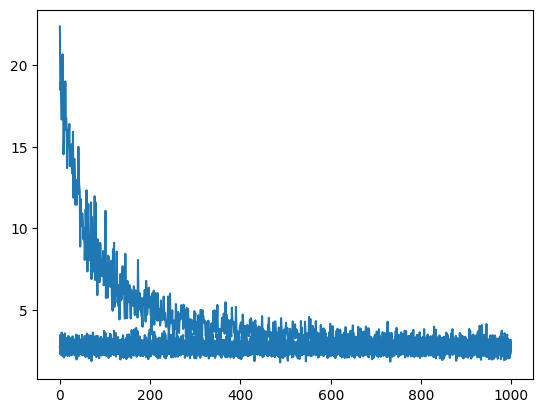

In [112]:
plt.plot(stepi, lossi)

In [122]:
# loss over training set

emb = C[Xtr] # (60, 3, 2)
h = (emb.view(-1,15) @ W1 + b1).tanh() # (60, 100)
logits = h @ W2 + b2 # (60, 64)
#counts = logits.exp()
#prob = counts / counts.sum(1, keepdim=True) # normalizing
#loss = -prob[Tensor.arange(60), Y].log().mean()
loss = Tensor.cross_entropy(logits, Ytr)
print(f'empirical loss: {loss.numpy()}')

empirical loss: 2.4871115684509277


In [123]:
# loss over dev test

emb = C[Xdev] # (60, 3, 2)
h = (emb.view(-1,15) @ W1 + b1).tanh() # (60, 100)
logits = h @ W2 + b2 # (60, 64)
#counts = logits.exp()
#prob = counts / counts.sum(1, keepdim=True) # normalizing
#loss = -prob[Tensor.arange(60), Y].log().mean()
loss = Tensor.cross_entropy(logits, Ydev)
loss.realize()
print(f'empirical loss: {loss.item()}')

empirical loss: 2.889242172241211


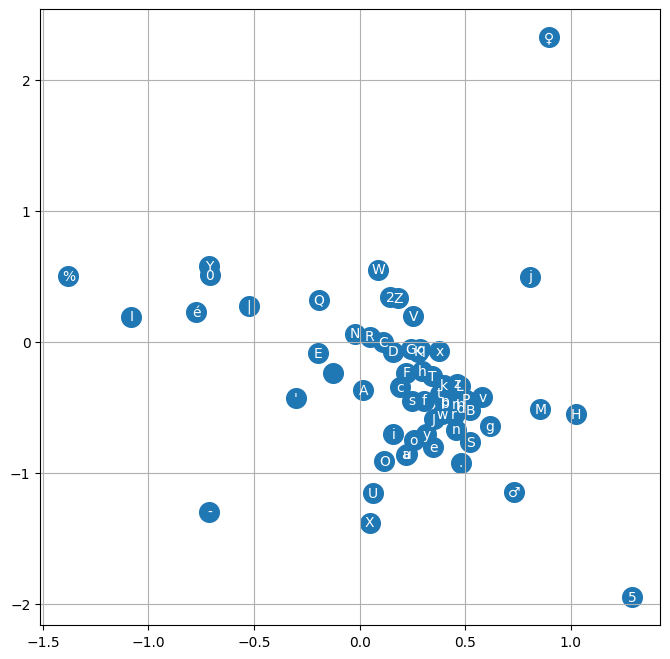

In [67]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data(), C[:,1].data(), s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color="white")
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10% of data set

In [127]:
# sample from the model

for _ in range(10):
    out = []
    context = [0] * block_size # initialize with all ||| starting chars
    while True:
        emb = C[Tensor(context)] # (1, block_size, d)
        h = (emb.view(1, -1) @ W1 + b1).tanh()
        logits = h @ W2 + b2
        probs = logits.softmax(axis=1)
        ix = probs.multinomial(num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

londaguppe|
Riyetundichigmetl Forn|
TeKdochodirdeirde|
Gabivoolhurolass|
Zeropulire|
Eesk o|
Qweakgosgoot|
Bes|
Duza|
Hlubl|
